In [1]:
# 📦 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# 📁 2. Load AQI Label File
aqi_df = pd.read_csv(r'C:\Users\kotaa\Downloads\AQI\AQI\DATA\IND_and_Nep_AQI_Dataset.csv')
print(aqi_df[['Filename', 'AQI', 'AQI_Class']].head())
print(aqi_df.columns)

                         Filename  AQI    AQI_Class
0  BRI_Un_2023-02-02- 12.00-9.jpg  158  d_Unhealthy
1  BRI_Un_2023-02-02- 12.00-8.jpg  158  d_Unhealthy
2  BRI_Un_2023-02-02- 12.00-7.jpg  158  d_Unhealthy
3  BRI_Un_2023-02-02- 12.00-6.jpg  158  d_Unhealthy
4  BRI_Un_2023-02-02- 12.00-5.jpg  158  d_Unhealthy
Index(['Location', 'Filename', 'Year', 'Month', 'Day', 'Hour', 'AQI', 'PM2.5',
       'PM10', 'O3', 'CO', 'SO2', 'NO2', 'AQI_Class'],
      dtype='object')


In [3]:
# Normalize filenames for easier matching
aqi_df['Filename'] = aqi_df['Filename'].str.strip()

In [4]:
# Base folders for classes
base_dirs = {
    'a_Good': r'C:\Users\kotaa\Downloads\AQI\AQI\DATA\IND_and_NEP\a_Good',
    'b_Moderate': r'C:\Users\kotaa\Downloads\AQI\AQI\DATA\IND_and_NEP\b_Moderate',
    'c_Unhealthy_for_Sensitive_Groups': r'C:\Users\kotaa\Downloads\AQI\AQI\DATA\IND_and_NEP\c_Unhealthy_for_Sensitive_Groups',
    'd_Unhealthy': r'C:\Users\kotaa\Downloads\AQI\AQI\DATA\IND_and_NEP\d_Unhealthy',
    'e_Very_Unhealthy': r'C:\Users\kotaa\Downloads\AQI\AQI\DATA\IND_and_NEP\e_Very_Unhealthy',
    'f_Severe': r'C:\Users\kotaa\Downloads\AQI\AQI\DATA\IND_and_NEP\f_Severe'
}
IMG_SIZE = (128, 128)

images = []
aqi_values = []
aqi_classes = []

In [6]:
from tqdm import tqdm

# Ensure filenames in both CSV and folder are consistent
aqi_df['Filename'] = aqi_df['Filename'].str.strip().str.lower()

images = []
aqi_values = []
aqi_classes = []

for folder_name, folder_path in base_dirs.items():
    print(f"🔍 Scanning folder: {folder_name}")
    for fname in tqdm(os.listdir(folder_path)):
        fname_clean = fname.strip().lower()
        full_path = os.path.join(folder_path, fname)

        # Match CSV entry (ignore full match, just check if fname starts with the same prefix)
        matched = aqi_df[aqi_df['Filename'].str.contains(fname_clean.split('.')[0])]
        if matched.empty:
            print(f"⚠️ No match in CSV for: {fname}")
            continue

        try:
            # Load image
            img = load_img(full_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0

            # Use first match
            images.append(img_array)
            aqi_values.append(matched.iloc[0]['AQI'])
            aqi_classes.append(matched.iloc[0]['AQI_Class'])

        except Exception as e:
            print(f"❌ Error loading {fname}: {e}")

print(f"\n✅ Successfully loaded {len(images)} matched images.")


🔍 Scanning folder: a_Good


100%|██████████| 1541/1541 [00:07<00:00, 206.56it/s]


🔍 Scanning folder: b_Moderate


100%|██████████| 1573/1573 [00:09<00:00, 168.23it/s]


🔍 Scanning folder: c_Unhealthy_for_Sensitive_Groups


100%|██████████| 2863/2863 [00:19<00:00, 147.33it/s]


🔍 Scanning folder: d_Unhealthy


100%|██████████| 2622/2622 [00:17<00:00, 150.54it/s]


🔍 Scanning folder: e_Very_Unhealthy


100%|██████████| 2194/2194 [00:14<00:00, 150.63it/s]


🔍 Scanning folder: f_Severe


100%|██████████| 1447/1447 [00:09<00:00, 149.58it/s]


✅ Successfully loaded 12240 matched images.


In [7]:
# Encode classes
le = LabelEncoder()
class_encoded = le.fit_transform(aqi_classes)
class_onehot = to_categorical(class_encoded)

X = np.array(images)
y_aqi = np.array(aqi_values)
y_class = class_onehot

print("✅ AQI Classes:", le.classes_)

✅ AQI Classes: ['a_Good' 'b_Moderate' 'c_Unhealthy_for_Sensitive_Groups' 'd_Unhealthy'
 'e_Very_Unhealthy' 'f_Severe']


In [8]:
# 📊 5. Prepare Dataset
X = np.array(images)
y_aqi = np.array(aqi_values)
y_class = class_onehot

X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(
    X, y_aqi, y_class, test_size=0.2, random_state=42
)


In [9]:
# 🧠 6. Define CNN Model
inp = Input(shape=(128, 128, 3))
x = Conv2D(32, (3,3), activation='relu')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

out_reg = Dense(1, name='aqi_output')(x)
out_cls = Dense(len(le.classes_), activation='softmax', name='class_output')(x)

model = Model(inputs=inp, outputs=[out_reg, out_cls])
model.compile(
    optimizer=Adam(0.001),
    loss={'aqi_output': 'mse', 'class_output': 'categorical_crossentropy'},
    metrics={'aqi_output': 'mae', 'class_output': 'accuracy'}
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [10]:
# 🏋️‍♂️ 7. Train the Model
history = model.fit(
    X_train,
    {'aqi_output': y_train_reg, 'class_output': y_train_cls},
    validation_data=(X_test, {'aqi_output': y_test_reg, 'class_output': y_test_cls}),
    epochs=25,
    batch_size=32
)


Epoch 1/25
306/306 [==============================] - 86s 277ms/step - loss: 8216.0225 - aqi_output_loss: 8197.7441 - class_output_loss: 18.2717 - aqi_output_mae: 68.3301 - class_output_accuracy: 0.2016 - val_loss: 5238.6646 - val_aqi_output_loss: 5232.4365 - val_class_output_loss: 6.2268 - val_aqi_output_mae: 53.0342 - val_class_output_accuracy: 0.2913
Epoch 2/25
306/306 [==============================] - 67s 218ms/step - loss: 5810.4038 - aqi_output_loss: 5803.4634 - class_output_loss: 6.9432 - aqi_output_mae: 56.6631 - class_output_accuracy: 0.2751 - val_loss: 4739.6606 - val_aqi_output_loss: 4737.4507 - val_class_output_loss: 2.2097 - val_aqi_output_mae: 50.6955 - val_class_output_accuracy: 0.3117
Epoch 3/25
306/306 [==============================] - 62s 202ms/step - loss: 5041.0381 - aqi_output_loss: 5038.3091 - class_output_loss: 2.7296 - aqi_output_mae: 52.9450 - class_output_accuracy: 0.3368 - val_loss: 3878.3057 - val_aqi_output_loss: 3876.6543 - val_class_output_loss: 1.6503 

In [18]:
model.save("aqi_combine_two_model.h5", include_optimizer=False)


In [19]:
# Either train the model first
# model.fit(...)

# Or load a previously saved model
from tensorflow.keras.models import load_model
model = load_model("aqi_combine_two_model.h5", compile=False)


In [20]:
from sklearn.preprocessing import LabelEncoder

# Same order used during training
class_labels = ['a_Good','b_Moderate','c_Unhealthy_for_Sensitive_Groups' 'd_Unhealthy', 'e_Very_Unhealthy', 'f_Severe']
le = LabelEncoder()
le.fit(class_labels)


LabelEncoder()

In [21]:
# 🔮 8. Predict From New Image
def predict_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_aqi, pred_class = model.predict(img_array)
    class_label = le.inverse_transform([np.argmax(pred_class)])

    print(f"\n📷 Image: {os.path.basename(image_path)}")
    print(f"🔢 Predicted AQI: {pred_aqi[0][0]:.2f}")
    print(f"🏷️ AQI Class: {class_label[0]}")

In [22]:
# ✅ Example Prediction
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\IND_and_NEP\b_Moderate\BENGR_Mod_2023-02-21-08.30-1-1.jpg')
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\IND_and_NEP\d_Unhealthy\BIR_UH_2023-03-16-12.30-1-43.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\vamsh\\OneDrive\\Documents\\AQI\\DATA\\IND_and_NEP\\b_Moderate\\BENGR_Mod_2023-02-21-08.30-1-1.jpg'

In [59]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load CSV
aqi_df = pd.read_csv(r"C:\Users\vamsh\OneDrive\Documents\AQI\DATA\IND_and_Nep_AQI_Dataset.csv")

# Mapping short codes to full location names
location_map = {
    "BENGR": "Bengaluru",
    "BIR": "Biratnagar, Nepal",
    "DIM": "Dimapur, Nagaland",
    "DEL": "ITO, Delhi",
    "NOIDA": "Knowledge park, Greater Noida",
    "MUM": "Mumbai",
    "FBD": "New Ind Town, Faridabad",
    "TN": "Tamil Nadu"
    # Add more as needed
}

def get_aqi_info(aqi_value):
    if aqi_value <= 50:
        return "Good", "Air quality is considered satisfactory.", "Green"
    elif aqi_value <= 100:
        return "Moderate", "Acceptable air quality; some pollutants may affect sensitive individuals.", "Yellow"
    elif aqi_value <= 150:
        return "Unhealthy for Sensitive Groups", "Sensitive individuals may experience health effects.", "Orange"
    elif aqi_value <= 200:
        return "Unhealthy", "Everyone may begin to experience health effects.", "Red"
    elif aqi_value <= 300:
        return "Very Unhealthy", "Health alert: serious effects for everyone.", "Purple"
    else:
        return "Hazardous", "Health warning of emergency conditions.", "Maroon"

IMG_SIZE = (128, 128)

def predict_image(image_path):
    # Preprocess image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred_aqi, pred_class = model.predict(img_array)
    predicted_value = pred_aqi[0][0]
    class_label = le.inverse_transform([np.argmax(pred_class)])

    filename = os.path.basename(image_path)
    try:
        match = re.match(r"([A-Z]+)_[A-Za-z]+_(\d{4})-(\d{2})-(\d{2})", filename)
        if match:
            short_code = match.group(1)
            location = location_map.get(short_code.upper(), short_code)
            year = int(match.group(2))
            month = int(match.group(3))
            day = int(match.group(4))

            match_df = aqi_df[
                (aqi_df['Location'].str.lower() == location.lower()) &
                (aqi_df['Year'] == year) &
                (aqi_df['Month'] == month) &
                (aqi_df['Day'] == day)
            ]

            if not match_df.empty:
                actual_aqi = match_df.iloc[0]["AQI"]
                actual_class = match_df.iloc[0]["AQI_Class"]
                print(f"\n📍 Location: {location}, 📅 Date: {year}-{month:02d}-{day:02d}")
                print(f"🎯 True AQI: {actual_aqi}, Class: {actual_class}")
            else:
                print(f"\n⚠️ No matching record found in CSV for: {location}, {year}-{month:02d}-{day:02d}")
        else:
            print(f"\n⚠️ Filename format not recognized for: {filename}")
    except Exception as e:
        print(f"\n⚠️ Error parsing filename '{filename}': {e}")

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # AQI category info
    category, health_message, color = get_aqi_info(predicted_value)

    # Output
    print(f"\n📷 Image: {filename}")
    print(f"🔢 Predicted AQI: {predicted_value:.2f}")
    print(f"🏷️ AQI Class: {class_label[0]}")
    print(f"📊 AQI Category: {category}")
    print(f"💬 Health Message: {health_message}")
    print(f"🎨 AQI Color: {color}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

📍 Location: Bengaluru, 📅 Date: 2023-02-21
🎯 True AQI: 56, Class: b_Moderate


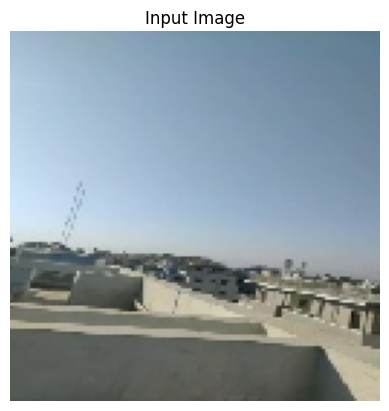


📷 Image: BENGR_Mod_2023-02-21-08.30-1-1.jpg
🔢 Predicted AQI: 39.05
🏷️ AQI Class: a_Good
📊 AQI Category: Good
💬 Health Message: Air quality is considered satisfactory.
🎨 AQI Color: Green
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

📍 Location: Biratnagar, Nepal, 📅 Date: 2023-03-16
🎯 True AQI: 154, Class: d_Unhealthy


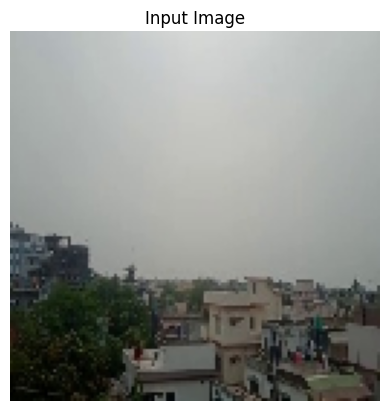


📷 Image: BIR_UH_2023-03-16-12.30-1-43.jpg
🔢 Predicted AQI: 117.17
🏷️ AQI Class: e_Very_Unhealthy
📊 AQI Category: Unhealthy for Sensitive Groups
💬 Health Message: Sensitive individuals may experience health effects.
🎨 AQI Color: Orange
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

📍 Location: ITO, Delhi, 📅 Date: 2023-02-07
🎯 True AQI: 449, Class: f_Severe


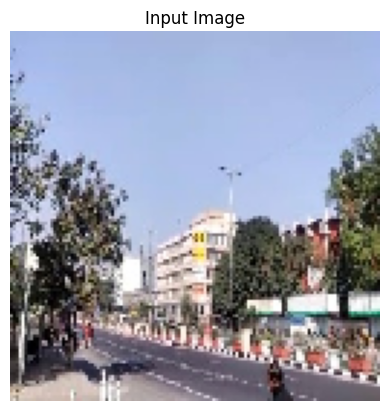


📷 Image: DEL_SEV_2023-02-07-14.00-1-8.jpg
🔢 Predicted AQI: 359.26
🏷️ AQI Class: f_Severe
📊 AQI Category: Hazardous
💬 Health Message: Health warning of emergency conditions.
🎨 AQI Color: Maroon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

📍 Location: Bengaluru, 📅 Date: 2023-02-19
🎯 True AQI: 41, Class: a_Good


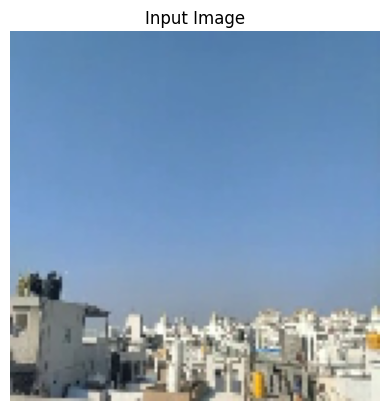


📷 Image: BENGR_Good_2023-02-19-08.30-1-5.jpg
🔢 Predicted AQI: 73.58
🏷️ AQI Class: a_Good
📊 AQI Category: Moderate
💬 Health Message: Acceptable air quality; some pollutants may affect sensitive individuals.
🎨 AQI Color: Yellow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

📍 Location: Bengaluru, 📅 Date: 2023-02-03
🎯 True AQI: 136, Class: c_Unhealthy_for_Sensitive_Groups


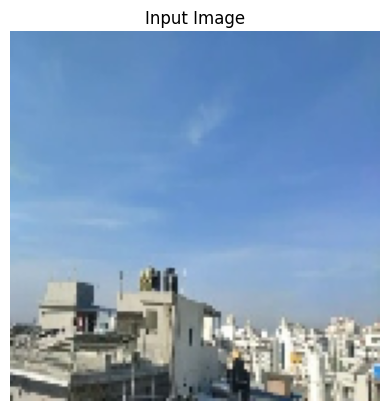


📷 Image: BENGR_UHFSG_2023-02-03-08.30-1-5.jpg
🔢 Predicted AQI: 78.42
🏷️ AQI Class: a_Good
📊 AQI Category: Moderate
💬 Health Message: Acceptable air quality; some pollutants may affect sensitive individuals.
🎨 AQI Color: Yellow


In [69]:
# ✅ Example Prediction
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\IND_and_NEP\b_Moderate\BENGR_Mod_2023-02-21-08.30-1-1.jpg')
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\IND_and_NEP\d_Unhealthy\BIR_UH_2023-03-16-12.30-1-43.jpg')
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\IND_and_NEP\f_Severe\DEL_SEV_2023-02-07-14.00-1-8.jpg')
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\IND_and_NEP\a_Good\BENGR_Good_2023-02-19-08.30-1-5.jpg')
predict_image(r'C:\Users\vamsh\OneDrive\Documents\AQI\DATA\IND_and_NEP\c_Unhealthy_for_Sensitive_Groups\BENGR_UHFSG_2023-02-03-08.30-1-5.jpg')

In [62]:
import matplotlib.pyplot as plt

def plot_aqi_trend(location_name):
    # Filter data for the given location
    df = aqi_df[aqi_df["Location"].str.lower() == location_name.lower()].copy()

    if df.empty:
        print(f"❌ No data found for location: {location_name}")
        return

    # Create a datetime column for sorting and plotting
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df.sort_values('Date', inplace=True)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['AQI'], marker='o', linestyle='-', color='blue', label='AQI')
    plt.title(f"AQI Trend Over Time - {location_name}")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


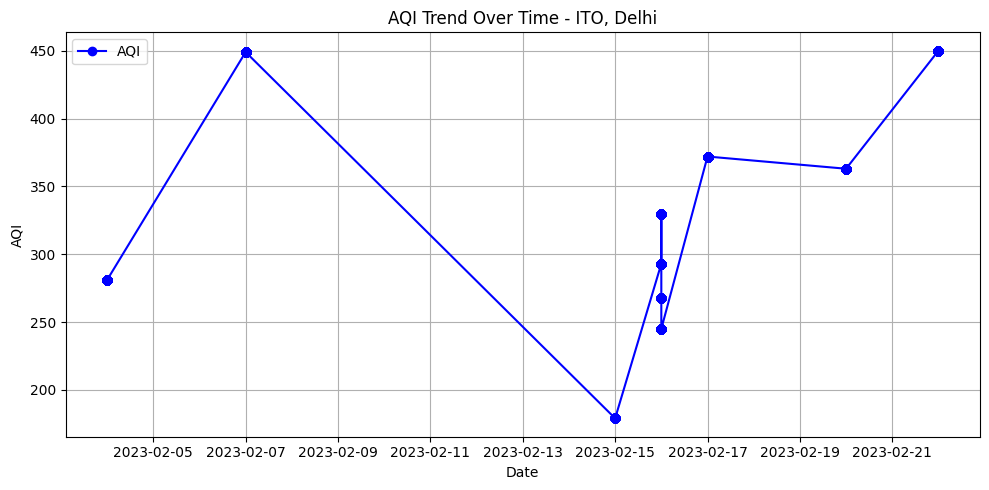

In [65]:
plot_aqi_trend("ITO, Delhi")


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_aqi_heatmap(location_name):
    # Filter data for selected location
    df = aqi_df[aqi_df["Location"].str.lower() == location_name.lower()].copy()
    
    if df.empty:
        print(f"❌ No data found for location: {location_name}")
        return

    # Pivot table for heatmap
    heatmap_data = df.pivot_table(
        index='Year', 
        columns='Month', 
        values='AQI', 
        aggfunc='mean'
    )

    # Plot
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        fmt=".0f", 
        cmap="YlOrRd", 
        linewidths=0.5, 
        cbar_kws={'label': 'AQI'}
    )
    plt.title(f"📊 Monthly Average AQI Heatmap - {location_name}")
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.tight_layout()
    plt.show()


C:\Users\vamsh\AppData\Local\Temp\ipykernel_15716\2581834638.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\vamsh\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


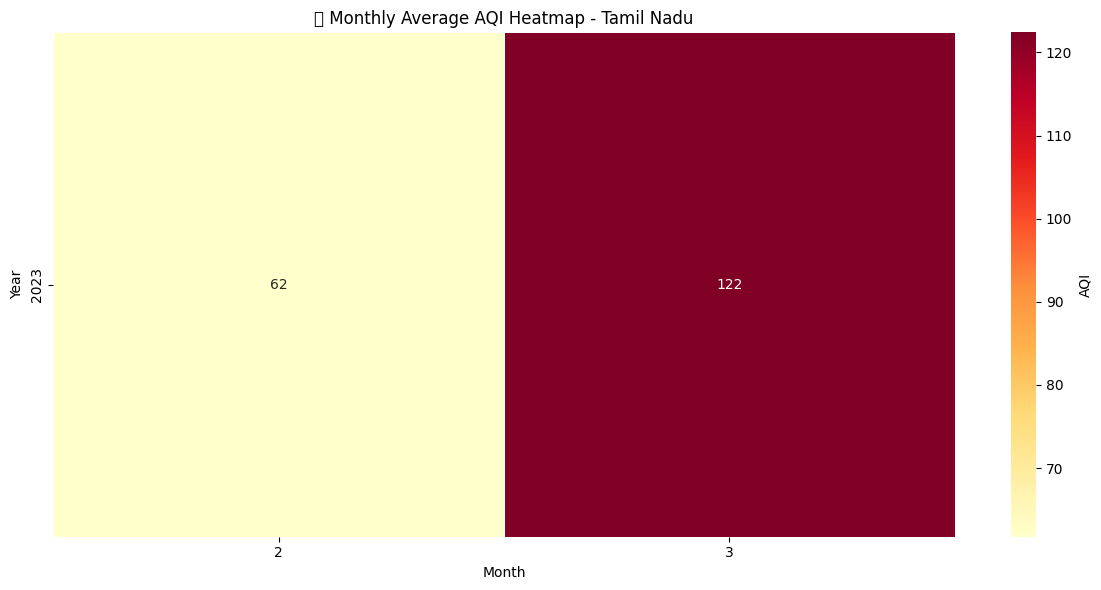

In [68]:
plot_aqi_heatmap("Tamil Nadu")
